In [40]:
# Utilities
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications import Xception
from keras.optimizers import Adam, Adamax
from keras import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Veri yollarını belirtin
data_dir = "/content/drive/My Drive/kaan-oral_cancer/Oral_cancer_intraoral_cameras_images/original"  # Veri klasörünün kök dizini
class_names = ["0", "1"]  # Sınıf adları

Mounted at /content/drive


In [3]:
import os

# Sınıf adları
class_names = ["0", "1"]

# Toplam etiket ve resim sayıları
total_labels = 0
total_images = 0

# Her sınıf için etiket ve resim sayılarını hesapla
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_labels = len(os.listdir(class_dir))
    class_images = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])  # .jpg uzantılı dosyaları say

    total_labels += class_labels
    total_images += class_images

    print(f"Sınıf: {class_name}, Etiket Sayısı: {class_labels}, Resim Sayısı: {class_images}")

# Toplam etiket ve resim sayılarını yazdır
print(f"\nToplam Etiket Sayısı: {total_labels}")
print(f"Toplam Resim Sayısı: {total_images}")


Sınıf: 0, Etiket Sayısı: 165, Resim Sayısı: 165
Sınıf: 1, Etiket Sayısı: 158, Resim Sayısı: 158

Toplam Etiket Sayısı: 323
Toplam Resim Sayısı: 323


In [9]:

# Data and Labels Collection
data = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        data.append(cv2.resize(img, (71, 71)))
        labels.append(class_name)

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [11]:
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

from keras.utils import to_categorical
# Convert training labels to one-hot encoding
train_labels_onehot = to_categorical(train_labels, num_classes=2)

# Convert testing labels to one-hot encoding
test_labels_onehot = to_categorical(test_labels, num_classes=2)

In [41]:
# Xception Model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))

# Freeze layers
for layer in xception_model.layers:
    layer.trainable = False

In [42]:
# Build Model
model = Sequential()
model.add(xception_model)
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))

In [49]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[metrics.Precision(), metrics.Recall(), 'binary_accuracy', 'accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, model='auto', factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [50]:
# Train Model
history = model.fit(train_data, train_labels_onehot, epochs=10, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/10
7/7 [==============================] - 4s 218ms/step - loss: 34.7778 - precision_4: 0.6076 - recall_4: 0.4660 - binary_accuracy: 0.5825 - accuracy: 0.6019 - val_loss: 34.0537 - val_precision_4: 0.5000 - val_recall_4: 1.0000 - val_binary_accuracy: 0.5000 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 0s 34ms/step - loss: 21.8258 - precision_4: 0.5435 - recall_4: 0.7282 - binary_accuracy: 0.5583 - accuracy: 0.5485 - val_loss: 16.6313 - val_precision_4: 0.6154 - val_recall_4: 0.4615 - val_binary_accuracy: 0.5865 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 0s 33ms/step - loss: 9.5906 - precision_4: 0.7154 - recall_4: 0.4272 - binary_accuracy: 0.6286 - accuracy: 0.6359 - val_loss: 12.0852 - val_precision_4: 0.5385 - val_recall_4: 0.9423 - val_binary_accuracy: 0.5673 - val_accuracy: 0.5962 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 0s 18ms/step - loss: 5.3483 - precision_4: 0.6517 

In [51]:
from sklearn.metrics import classification_report

predictions = model.predict(test_data)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels_onehot, axis=1)

class_report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(class_report)


3/3 [==============================] - 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.56      0.64        34
           1       0.62      0.81      0.70        31

    accuracy                           0.68        65
   macro avg       0.69      0.68      0.67        65
weighted avg       0.70      0.68      0.67        65



In [52]:
# Model Evaluation
evaluation = model.evaluate(test_data, test_labels_onehot)
test_accuracy = evaluation[1]
print("Test accuracy:", test_accuracy)

3/3 [==============================] - 0s 10ms/step - loss: 4.8335 - precision_4: 0.6338 - recall_4: 0.6923 - binary_accuracy: 0.6462 - accuracy: 0.6769
Test accuracy: 0.6338028311729431


In [53]:
# ROC Curve and AUC
predicted_probabilities = model.predict(test_data)
true_labels_positive = test_labels_onehot[:, 1]
fpr, tpr, thresholds = roc_curve(true_labels_positive, predicted_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

3/3 [==============================] - 0s 7ms/step


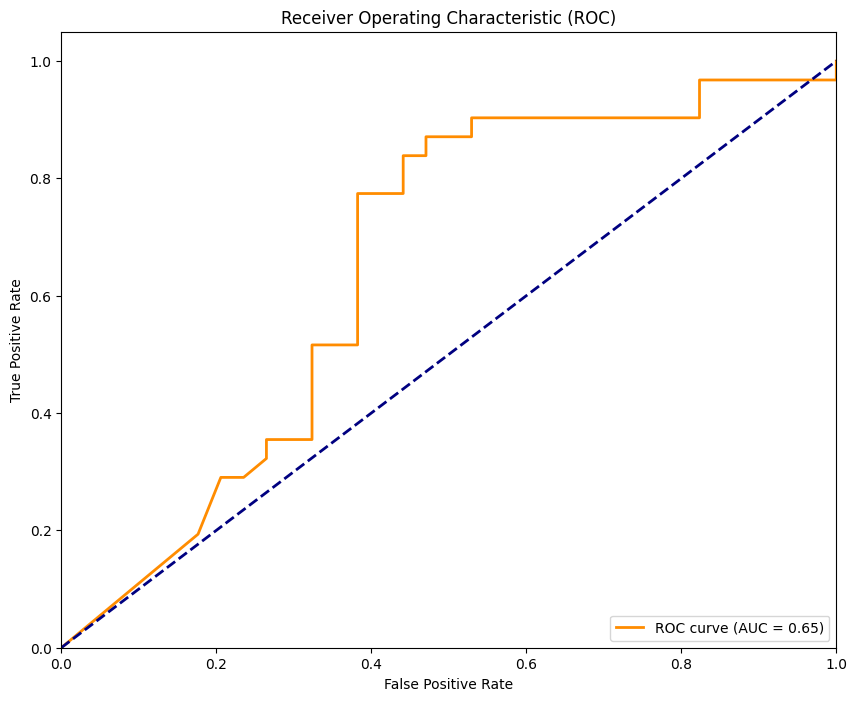

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

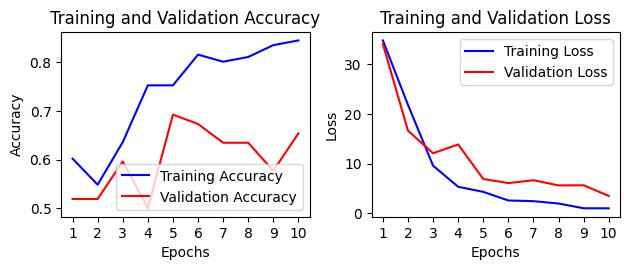

In [55]:
# Extracting training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

plt.tight_layout()
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

3/3 [==============================] - 0s 7ms/step
Confusion Matrix:
[[19 15]
 [ 6 25]]


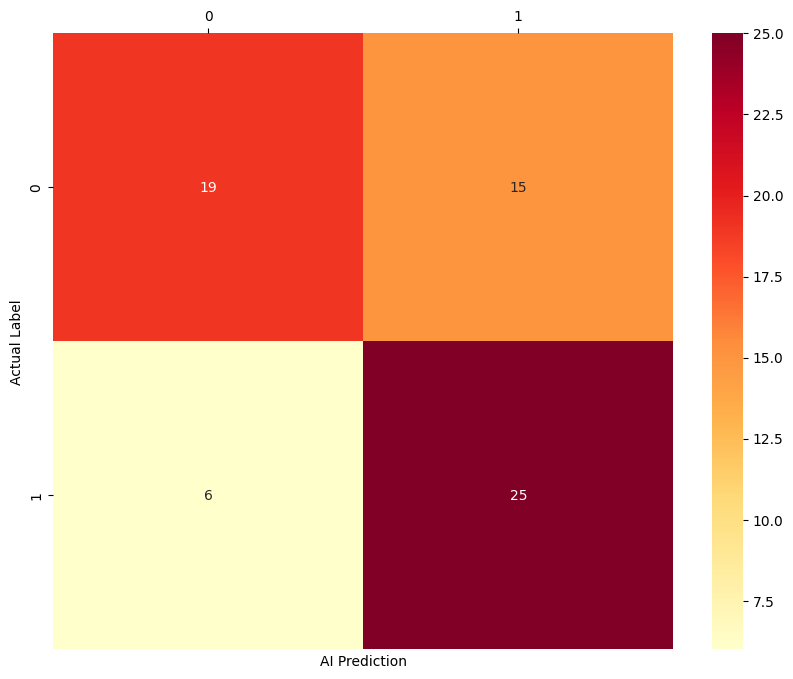

In [57]:
# Karışıklık matrisini görselleştir
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=class_names, yticklabels=class_names)
hm.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False)
plt.xlabel('AI Prediction')
plt.ylabel('Actual Label')
plt.show()